In [1]:
# load libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# read data from data.tsv
raw_data = pd.read_csv('data.tsv',delimiter='\t')
raw_data.head()

,Name,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,Sample_1,1,-3.862189,4.005114,5.334341,-1.597156,0.172337,-2.210584,5.217761,2.688107,-3.484756,0.502449
1,Sample_2,1,-4.332433,4.791025,6.994099,1.379125,2.893778,-2.479178,2.783295,1.083796,-2.690662,2.050993
2,Sample_3,1,-5.422645,3.436808,3.450239,-5.217882,1.280875,-1.875442,6.393865,-0.308130,-1.643508,2.103380
3,Sample_4,1,-6.102196,4.213826,5.166152,-1.146564,2.940510,-2.589440,4.567969,-1.164663,-2.404096,3.172213
4,Sample_5,1,-4.483278,4.977083,5.006717,0.726806,0.128842,-1.752203,7.114059,1.773177,-2.254331,1.719560


In [3]:
# drop Name column as it does not provide any important info for us (nominal data)
raw_data = raw_data.drop(['Name'], axis=1)
raw_data.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1,-3.862189,4.005114,5.334341,-1.597156,0.172337,-2.210584,5.217761,2.688107,-3.484756,0.502449
1,1,-4.332433,4.791025,6.994099,1.379125,2.893778,-2.479178,2.783295,1.083796,-2.690662,2.050993
2,1,-5.422645,3.436808,3.450239,-5.217882,1.280875,-1.875442,6.393865,-0.308130,-1.643508,2.103380
3,1,-6.102196,4.213826,5.166152,-1.146564,2.940510,-2.589440,4.567969,-1.164663,-2.404096,3.172213
4,1,-4.483278,4.977083,5.006717,0.726806,0.128842,-1.752203,7.114059,1.773177,-2.254331,1.719560


In [4]:
# define inputs and targets
targets = raw_data.iloc[:,:1]
inputs = raw_data.iloc[:,1:]

In [5]:
# devide data in test and train
from sklearn.model_selection import train_test_split
raw_x_train, x_test, raw_y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=20)

## Check data quality

In [6]:
x_train = raw_x_train.copy()
y_train = raw_y_train.copy()

In [7]:
# check we have about the same 0 and 1 for target
ratio_y_1 = y_train['y'].sum()/y_train.shape[0]
ratio_y_1, y_train['y'].unique() # great, exactly 50%

(0.5, array([1, 0], dtype=int64))

In [8]:
x_train.describe(include='all') 
# inputs are not scaled, but values seem to be of the same order
# no obvious otliers, maybe in the higher end of X1, X4, X8 and X9
# no missing values

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,-5.202782,4.084610,2.156567,-1.331564,1.920150,-2.055685,5.071449,0.191459,-1.193139,2.050923
std,2.222950,1.135082,2.706600,2.056383,1.142951,0.559646,1.507529,1.874831,1.859554,0.490913
min,-10.098214,1.459342,-4.276636,-6.022067,-0.123066,-3.511152,0.965622,-4.253986,-5.939233,1.014622
25%,-6.523894,3.388455,0.162573,-2.719839,1.119985,-2.437339,4.135432,-0.982053,-2.380773,1.705572
50%,-5.122969,4.165016,2.180125,-1.388076,1.775912,-2.129324,4.949938,0.324068,-1.257339,2.047749
75%,-3.421282,4.871213,4.131111,-0.077234,2.782939,-1.714779,6.245985,1.298053,0.035325,2.465561
max,-0.756248,6.919229,7.740567,4.562774,4.410060,-0.658039,8.260527,4.303564,3.344339,3.172213


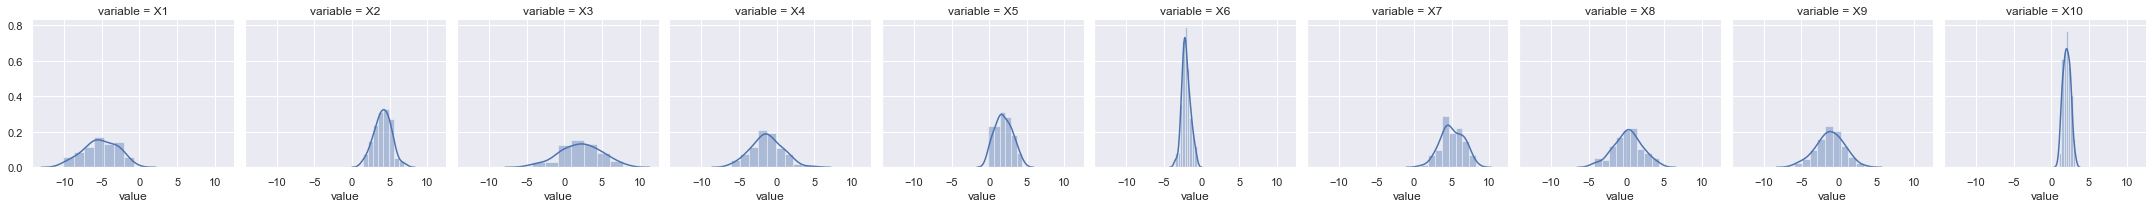

In [9]:
# check normality
f_grid = sns.FacetGrid(x_train.melt(), col="variable")
f_grid.map(sns.distplot, "value") # seems inputs shall be scaled

In [10]:
# check for multicolliearity: VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = x_train
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif # X2, X6, X7 and X10 have very high score -> must be collinear with the other inputs (especially X10 - maybe remove)

,VIF,Features
0,7.651294,X1
1,12.055679,X2
2,2.362216,X3
3,1.759662,X4
4,4.222427,X5
5,12.135276,X6
6,15.598133,X7
7,1.171099,X8
8,1.912391,X9
9,20.052422,X10


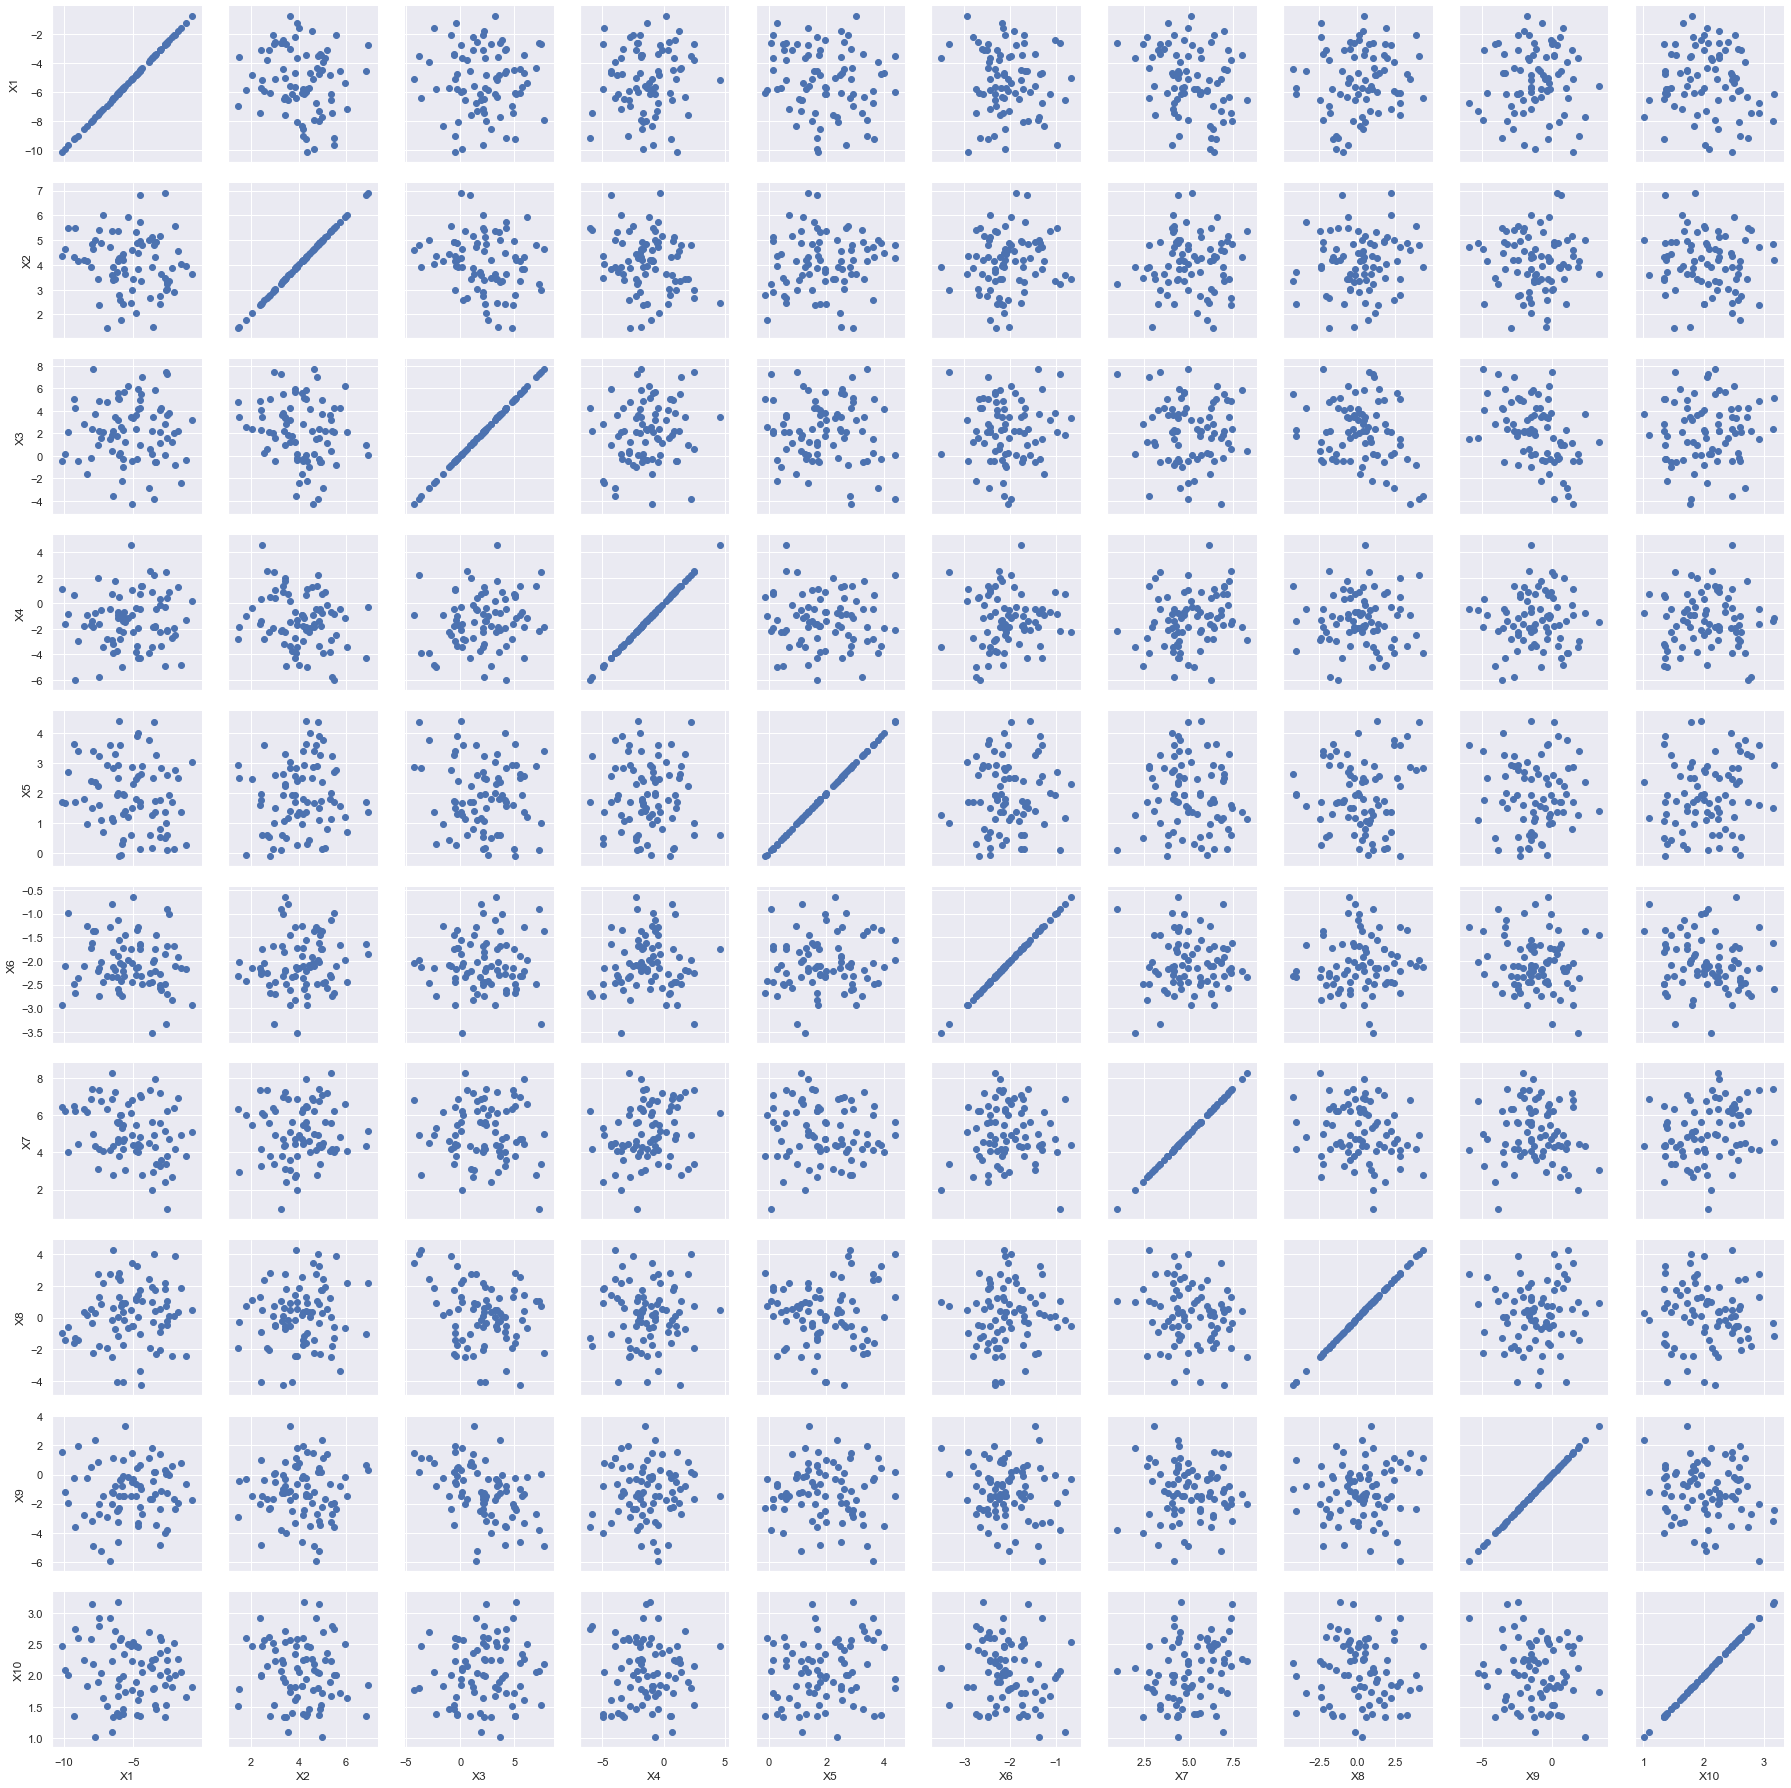

In [11]:
# check for multicollinearity
p_grid = sns.PairGrid(x_train)
p_grid = p_grid.map(plt.scatter) # no obvious multicollinearity though

## Try fit logistic regression with stats models (not pre-processed data)

In [12]:
# define target
y = y_train

In [13]:
# fit with all inputs
x1_all = x_train
x_all = sm.add_constant(x1_all)
reg_all = sm.Logit(y,x_all)
results_all = reg_all.fit()
results_all.summary() # only x2, x3 and x9 seem to be significant, maybe also X10

Optimization terminated successfully.
         Current function value: 0.199437
         Iterations 9


C:\tools\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:                          Logit   Df Residuals:                       69
Method:                           MLE   Df Model:                           10
Date:                Tue, 05 Nov 2019   Pseudo R-squ.:                  0.7123
Time:                        09:41:49   Log-Likelihood:                -15.955
converged:                       True   LL-Null:                       -55.452
Covariance Type:            nonrobust   LLR p-value:                 7.904e-13
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2576      3.537     -0.356      0.722      -8.190       5.675
X1            -0.2522      0.229     -1.101      0.271      -0.701       0.197
X2            -0.9864      0.503     -1.961      0.050      -1.972      -0.001
X3             1.5557      0.471      3.301      0.001       0.632       2.480
X4            -0.1568      0.273     -0.573      0.566      -0.693       0.379
X5             0.6111      0.466      1.312      0.190      -0.302       1.524
X6            -1.1285      0.943     -1.196      0.232      -2.977       0.720
X7            -0.1557      0.439     -0.355      0.723      -1.016       0.704
X8             0.3312      0.305      1.086      0.277      -0.266       0.929
X9            -1.7298      0.583     -2.969      0.003      -2.872      -0.588
X10           -2.0740      1.268     -1.636      0.102      -4.559       0.411
==============================================================================

Possibly complete quasi-separation: A fraction 0.16 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [14]:
# confusion matrix and accuracy
pt = results_all.pred_table()
accuracy = (pt[0,0]+pt[1,1])/pt.sum()
print (pt, accuracy) # not bad, but might be overfitting

[[37.  3.]
 [ 3. 37.]] 0.925


## Scale inputs and try again

In [15]:
# standardize the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [16]:
np.mean(x_train_scaled, axis=0) # all means are around 0

array([-0.04311633,  0.00919184,  0.0153631 , -0.02820654, -0.01918652,
       -0.01734626,  0.01034923,  0.0226554 , -0.02389523,  0.04128387])

In [17]:
np.std(x_train_scaled, axis=0) # standard deviation is about 1

array([0.94832772, 1.04439347, 0.96756637, 0.9803686 , 1.02761897,
       1.04761734, 1.02522202, 0.97985017, 1.01364416, 0.92444952])

In [18]:
# fit with all inputs
x1_scaled_all = x_train_scaled
x_scaled_all = sm.add_constant(x1_scaled_all)
reg_scaled_all = sm.Logit(y,x_scaled_all)
results_scaled_all = reg_scaled_all.fit()
results_scaled_all.summary() # not much difference from unscaled version

Optimization terminated successfully.
         Current function value: 0.199437
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:                          Logit   Df Residuals:                       69
Method:                           MLE   Df Model:                           10
Date:                Tue, 05 Nov 2019   Pseudo R-squ.:                  0.7123
Time:                        09:41:49   Log-Likelihood:                -15.955
converged:                       True   LL-Null:                       -55.452
Covariance Type:            nonrobust   LLR p-value:                 7.904e-13
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0363      0.540      0.067      0.946      -1.022       1.095
x1            -0.5876      0.534     -1.101      0.271      -1.633       0.458
x2            -1.0653      0.543     -1.961      0.050      -2.130      -0.001
x3             4.3246      1.310      3.301      0.001       1.757       6.893
x4            -0.3268      0.570     -0.573      0.566      -1.444       0.790
x5             0.6754      0.515      1.312      0.190      -0.334       1.685
x6            -0.5991      0.501     -1.196      0.232      -1.581       0.382
x7            -0.2275      0.641     -0.355      0.723      -1.484       1.029
x8             0.6298      0.580      1.086      0.277      -0.507       1.766
x9            -3.1534      1.062     -2.969      0.003      -5.235      -1.072
x10           -1.0944      0.669     -1.636      0.102      -2.406       0.217
==============================================================================

Possibly complete quasi-separation: A fraction 0.16 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [19]:
# confusion matrix and accuracy
pt = results_scaled_all.pred_table()
accuracy = (pt[0,0]+pt[1,1])/pt.sum()
print (pt, accuracy) # same as before

[[37.  3.]
 [ 3. 37.]] 0.925


## Remove collinear inputs 

In [20]:
data_no_outliers = y_train.join(x_train)
q1 = data_no_outliers['X1'].quantile(0.99)
q4 = data_no_outliers['X4'].quantile(0.99)
q8 = data_no_outliers['X8'].quantile(0.99)
q9 = data_no_outliers['X9'].quantile(0.99)
data_no_outliers = data_no_outliers[data_no_outliers['X1']<q1]
data_no_outliers = data_no_outliers[data_no_outliers['X4']<q4]
data_no_outliers = data_no_outliers[data_no_outliers['X8']<q8]
data_no_outliers = data_no_outliers[data_no_outliers['X9']<q9]
data_no_outliers.describe()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.500000,-5.240746,4.120096,2.213271,-1.392723,1.918009,-2.054942,5.113970,0.120128,-1.272587,2.047236
std,0.503322,2.217727,1.146743,2.687721,1.966677,1.149496,0.559920,1.500581,1.860803,1.812060,0.497012
min,0.000000,-10.098214,1.459342,-4.276636,-6.022067,-0.123066,-3.511152,0.965622,-4.253986,-5.939233,1.014622
25%,0.000000,-6.594360,3.388455,0.162573,-2.719839,1.119985,-2.437339,4.171039,-1.043528,-2.389112,1.662496
50%,0.500000,-5.068372,4.196048,2.180125,-1.388076,1.775912,-2.132701,4.949938,0.133306,-1.257339,2.047749
75%,1.000000,-3.421282,4.886479,4.180552,-0.259689,2.714497,-1.714779,6.339594,1.298053,-0.015799,2.455640
max,1.000000,-1.200247,6.919229,7.740567,2.502094,4.410060,-0.658039,8.260527,4.034830,2.378136,3.172213


In [21]:
y_train_no_outliers = data_no_outliers.iloc[:,:1]
x_train_no_outliers = data_no_outliers.iloc[:,1:]

In [22]:
# fit with all inputs and no outliers
x1_no_outliers = x_train_no_outliers
x_no_outliers = sm.add_constant(x1_no_outliers)
reg_no_outliers = sm.Logit(y_train_no_outliers,x_no_outliers)
results_no_outliers = reg_no_outliers.fit()
results_no_outliers.summary() 

Optimization terminated successfully.
         Current function value: 0.204355
         Iterations 9


C:\tools\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:                          Logit   Df Residuals:                       65
Method:                           MLE   Df Model:                           10
Date:                Tue, 05 Nov 2019   Pseudo R-squ.:                  0.7052
Time:                        09:41:49   Log-Likelihood:                -15.531
converged:                       True   LL-Null:                       -52.679
Covariance Type:            nonrobust   LLR p-value:                 6.520e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7393      3.571     -0.487      0.626      -8.737       5.259
X1            -0.2118      0.236     -0.898      0.369      -0.674       0.251
X2            -0.9013      0.498     -1.811      0.070      -1.876       0.074
X3             1.5016      0.457      3.287      0.001       0.606       2.397
X4            -0.3075      0.353     -0.871      0.384      -0.999       0.384
X5             0.6427      0.465      1.383      0.167      -0.268       1.553
X6            -1.0290      0.953     -1.079      0.280      -2.898       0.840
X7            -0.0477      0.462     -0.103      0.918      -0.954       0.859
X8             0.2850      0.303      0.940      0.347      -0.309       0.879
X9            -1.6249      0.567     -2.866      0.004      -2.736      -0.514
X10           -2.1128      1.283     -1.647      0.100      -4.627       0.402
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [70]:
# confusion matrix and accuracy
pt = results_no_outliers.pred_table()
accuracy = (pt[0,0]+pt[1,1])/pt.sum()
print (pt, accuracy) # same as before

[[36.  2.]
 [ 3. 35.]] 0.9342105263157895


array([9.98705405e-01, 2.29713290e-02, 7.40911316e-01, 7.16147104e-03,
       9.97466848e-01, 9.99929789e-01, 5.41176195e-02, 5.63896722e-03,
       7.67797232e-01, 9.99974070e-01, 4.43621971e-01, 1.71911068e-01,
       4.83822296e-03, 9.99813391e-01, 7.90675370e-02, 2.28374793e-02,
       9.95982755e-01, 9.83707692e-01, 8.59738473e-01, 3.76975428e-01,
       3.01939414e-01, 3.07189899e-01, 1.52469314e-03, 4.58414867e-04,
       8.97916142e-01, 9.96316671e-01, 9.76639978e-01, 4.32402186e-02,
       2.51718940e-04, 9.99928252e-01, 3.22291059e-01, 2.31718201e-03,
       7.15842076e-01, 9.73774196e-01, 8.30681282e-05, 9.65669056e-01,
       2.07735925e-04, 4.78418658e-01, 1.55699585e-04, 3.19231699e-02,
       9.66898645e-02, 2.11398436e-01, 5.41121700e-01, 9.82455895e-01,
       9.36489429e-01, 9.99427367e-01, 2.40277132e-01, 9.78937498e-01,
       9.99990024e-01, 3.07998767e-04, 1.19566436e-01, 9.93780236e-01,
       9.99221674e-01, 2.32710630e-03, 2.71717752e-03, 9.92253483e-01,
      

In [24]:
# remove colinear unsignificant inputs
x_train_no_outliers_no_collinear = x_train_no_outliers.drop(['X1', 'X4', 'X5', 'X6', 'X7', 'X8'], axis=1)
x_test_no_collinear = x_test.drop(['X1', 'X4', 'X5', 'X6', 'X7', 'X8'], axis=1)
x_train_no_outliers_no_collinear.head()

,X2,X3,X9,X10
37,5.481906,4.228811,-3.575561,2.741472
51,3.866856,1.230129,0.612077,1.821844
35,5.936397,6.190375,-0.190441,2.497677
65,4.357042,-2.271498,-0.791513,1.386591
31,2.402319,4.898700,-2.052922,2.915298


In [25]:
# check VIF
variables = x_train_no_outliers_no_collinear
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif 

,VIF,Features
0,7.548014,X2
1,2.091642,X3
2,1.882986,X9
3,8.535444,X10


In [71]:
# fit with selected inputs and no outliers
x1_no_outliers_no_collinear = x_train_no_outliers_no_collinear
x_no_outliers_no_collinear = sm.add_constant(x1_no_outliers_no_collinear)
reg_no_outliers_no_collinear = sm.Logit(y_train_no_outliers,x_no_outliers_no_collinear)
results_no_outliers_no_collinear = reg_no_outliers_no_collinear.fit()
results_no_outliers_no_collinear.summary()

Optimization terminated successfully.
         Current function value: 0.250789
         Iterations 8


C:\tools\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,X2,X3,X9,X10
37,5.482,4.229,-3.576,2.741
51,3.867,1.230,0.612,1.822
35,5.936,6.190,-0.190,2.498
65,4.357,-2.271,-0.792,1.387
31,2.402,4.899,-2.053,2.915
...,...,...,...,...
98,3.432,3.451,-0.770,2.717
28,4.143,5.553,-4.599,1.831
95,2.673,0.629,-1.652,2.145
15,3.403,2.232,-1.298,1.342


In [27]:
# confusion matrix and accuracy
pt = results_no_outliers_no_collinear.pred_table()
accuracy = (pt[0,0]+pt[1,1])/pt.sum()
print (pt, accuracy) # same as before

[[32.  6.]
 [ 3. 35.]] 0.881578947368421


## Test models

In [28]:
len(y_test)

20

In [29]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
_x_test = sm.add_constant(x_test)
_x_test_no_collinear = sm.add_constant(x_test_no_collinear)
_x_test_scaled = sm.add_constant(x_test_scaled)

In [30]:
# reg_all
pred_values = results_scaled_all.predict(_x_test_scaled)
test_result_table = pd.DataFrame({'Value': pred_values})
test_result_table['Prediction'] = np.where(test_result_table['Value']>=0.5, 1, 0)
test_result_table['Actual'] = np.where(y_test==1, 1, 0)
test_result_table['Result'] = np.where(test_result_table['Prediction']==test_result_table['Actual'], True, False)
accuracy = test_result_table['Result'].sum()/test_result_table.shape[0]
accuracy

0.85

In [31]:
# reg_scaled_all
pred_values = results_scaled_all.predict(_x_test_scaled)
test_result_table = pd.DataFrame({'Value': pred_values})
test_result_table['Prediction'] = np.where(test_result_table['Value']>=0.5, 1, 0)
test_result_table['Actual'] = np.where(y_test==1, 1, 0)
test_result_table['Result'] = np.where(test_result_table['Prediction']==test_result_table['Actual'], True, False)
accuracy = test_result_table['Result'].sum()/test_result_table.shape[0]
accuracy

0.85

In [32]:
# reg_no_outliers
pred_values = results_no_outliers.predict(_x_test)
test_result_table = pd.DataFrame({'Value': pred_values})
test_result_table['Prediction'] = np.where(test_result_table['Value']>=0.5, 1, 0)
test_result_table['Actual'] = np.where(y_test==1, 1, 0)
test_result_table['Result'] = np.where(test_result_table['Prediction']==test_result_table['Actual'], True, False)
accuracy = test_result_table['Result'].sum()/test_result_table.shape[0]
accuracy

0.85

In [33]:
# reg_no_outliers_no_collinear
pred_values = results_no_outliers_no_collinear.predict(_x_test_no_collinear)
test_result_table = pd.DataFrame({'Value': pred_values})
test_result_table['Prediction'] = np.where(test_result_table['Value']>=0.5, 1, 0)
test_result_table['Actual'] = np.where(y_test==1, 1, 0)
test_result_table['Result'] = np.where(test_result_table['Prediction']==test_result_table['Actual'], True, False)
accuracy = test_result_table['Result'].sum()/test_result_table.shape[0]
accuracy

0.8

In [35]:
results_no_outliers_no_collinear.params

const   -0.224
X2      -0.442
X3       1.183
X9      -1.356
X10     -1.222
dtype: float64

In [36]:
def f(x,b0,b1):
    return np.array(np.exp(b0+x*b1) / (1 + np.exp(b0+x*b1)))

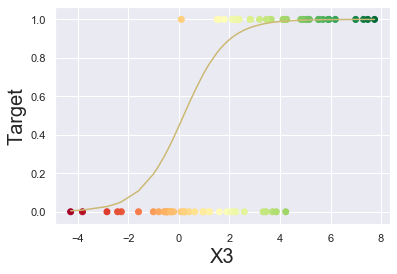

In [47]:
def f(x,b0,b1):
    return np.array(np.exp(b0+x*b1) / (1 + np.exp(b0+x*b1)))

f3_sorted = np.sort(f(x_train_no_outliers_no_collinear['X3'],results_no_outliers_no_collinear.params[0],results_no_outliers_no_collinear.params[2]))
x3_sorted = np.sort(np.array(x_train_no_outliers_no_collinear['X3']))

plt.scatter(x_train_no_outliers_no_collinear['X3'],y_train_no_outliers,c=x_train_no_outliers_no_collinear['X3'], cmap='RdYlGn')
plt.xlabel('X3', fontsize = 20)
plt.ylabel('Target', fontsize = 20)
plt.plot(x3_sorted,f3_sorted,color='C8')
plt.show()

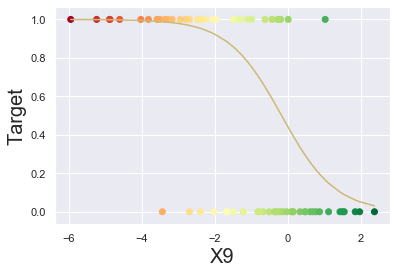

In [48]:
f9_sorted = np.sort(f(x_train_no_outliers_no_collinear['X9'],results_no_outliers_no_collinear.params[0],results_no_outliers_no_collinear.params[3]))
x9_sorted = np.sort(np.array(x_train_no_outliers_no_collinear['X9']))[::-1]

plt.scatter(x_train_no_outliers_no_collinear['X9'],y_train_no_outliers,c=x_train_no_outliers_no_collinear['X9'], cmap='RdYlGn')
plt.xlabel('X9', fontsize = 20)
plt.ylabel('Target', fontsize = 20)
plt.plot(x9_sorted,f9_sorted,color='C8')
plt.show()

In [ ]:
plt.scatter(x_train_no_outliers_no_collinear['X9'],y_train_no_outliers,c=x_train_no_outliers_no_collinear['X9'], cmap='RdYlGn')
plt.xlabel('X9', fontsize = 20)
plt.ylabel('Target', fontsize = 20)
plt.plot(x9_sorted,f9_sorted,color='C8')
plt.show()